In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

from collections import deque
import glob
import pickle

%matplotlib inline

/Users/vmandal/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Camera Calibration

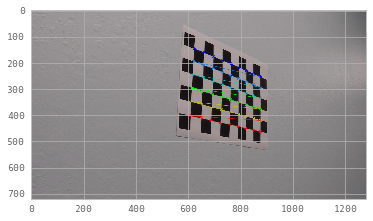

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        plt.imshow(img)
        

...


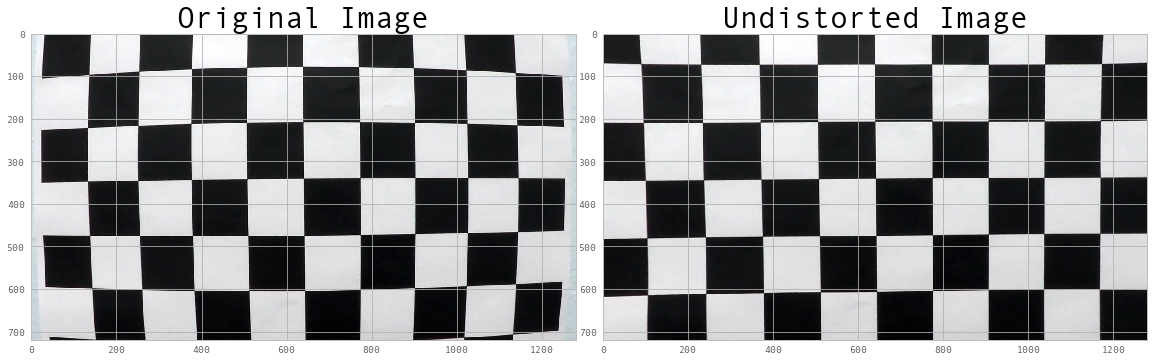

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1][1:], None,None)
pickle.dump({'mtx': mtx, 'dist': dist}, open("cam_calibration.p", "wb"))
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

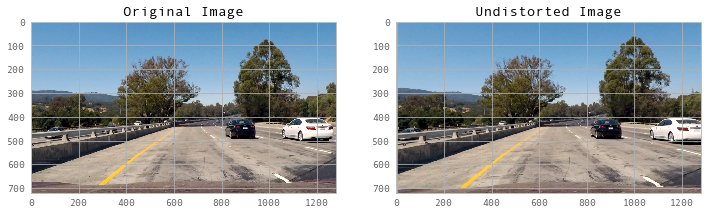

In [4]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1, 2, 2)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")

## Create thresholded binary images

In [41]:
def gaussian_blur(img, sigma):
    kernel_size = 11
    return cv2.GaussianBlur(img, (kernerl_size, kernel_size), sigma)

def abs_sobel_thresh(img, thresh_min=25, thresh_max=255, sobel_kernel=7, orient='x'):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    bin_output = np.zeros_like(scaled_sobel)
    bin_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return bin_output

def mag_thresh(img, sobel_kernel=7, thresh_min=25, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    bin_output = np.zeros_like(magnitude)
    bin_output[(magnitude >= thresh_min) & (magnitude <= thresh_max)] = 1

    return bin_output

def directional_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradient = np.arctan2(np.abs(sobely), np.abs(sobelx))
  
    dir_binary = np.zeros_like(gradient)
    dir_binary[(gradient > thresh_min) & (gradient <= thresh_max)] = 1
                       
    return dir_binary

def color_thresh(img, thresh_min=0, thresh_max=255):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    s = hls[:, :, 2]
    bin_output = np.zeros_like(s)
    bin_output[(s > thresh_min) & (s <= thresh_max)] = 1
    return bin_output

def transform_perspective(img, src, dst):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [37]:
src = np.float32([[490, 482],[810, 482],
                 [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                  [1250, 720],[40, 720]])


#def pipeline(img):
#    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
#    warped = transform_perspective

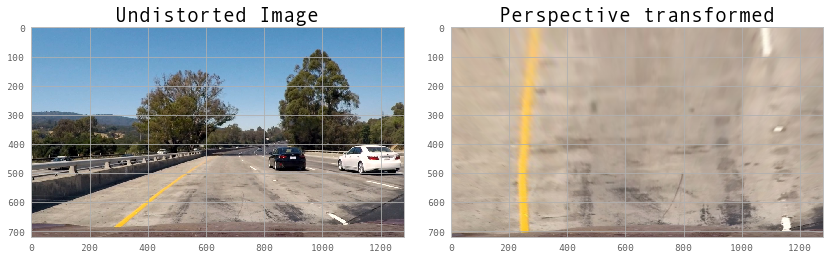

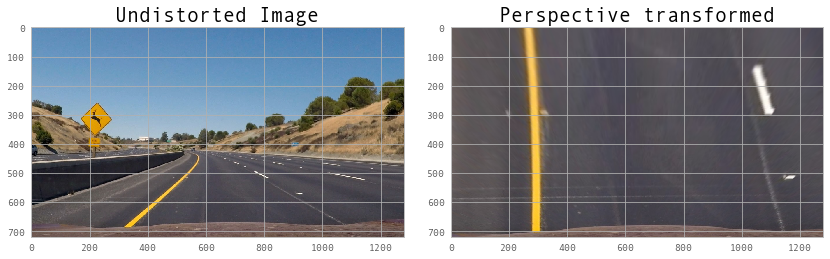

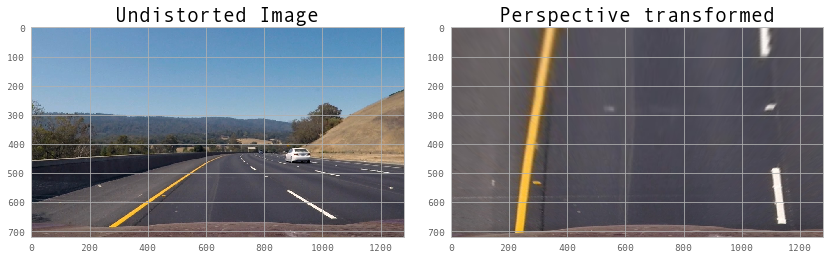

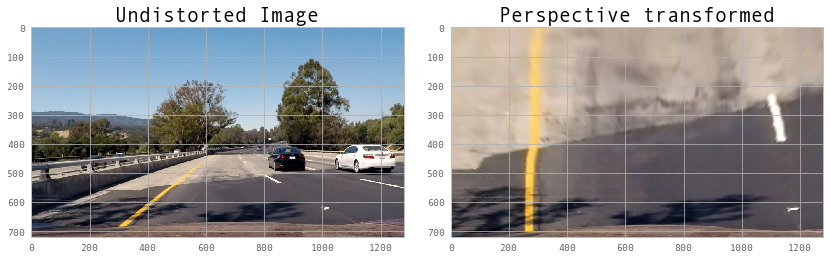

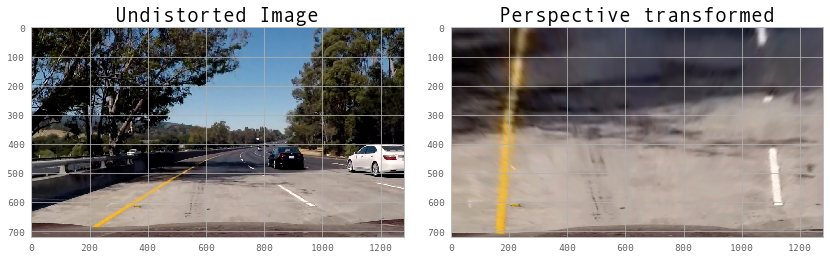

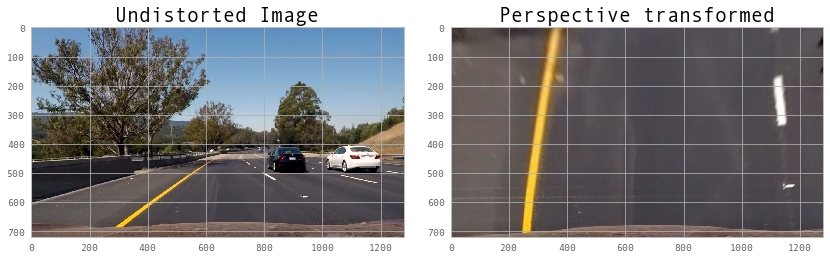

In [28]:
for fname in glob.glob("test_images/test*.jpg"):
    #fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    #img = cv2.resize(img, (720, 405))
    
    warped = transform_perspective(img, src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Perspective transformed', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


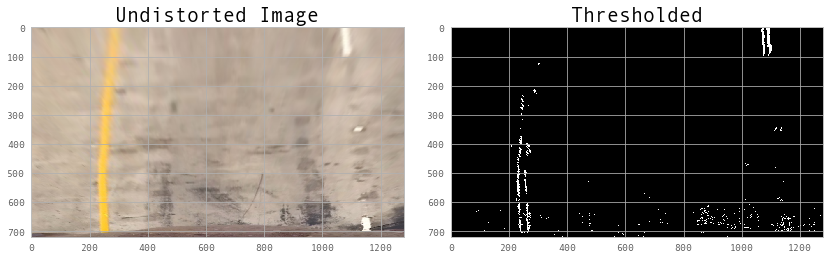

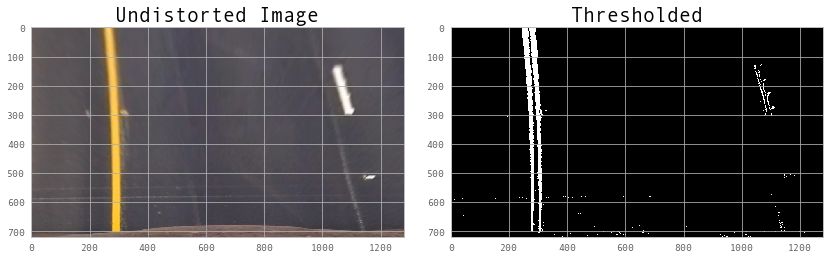

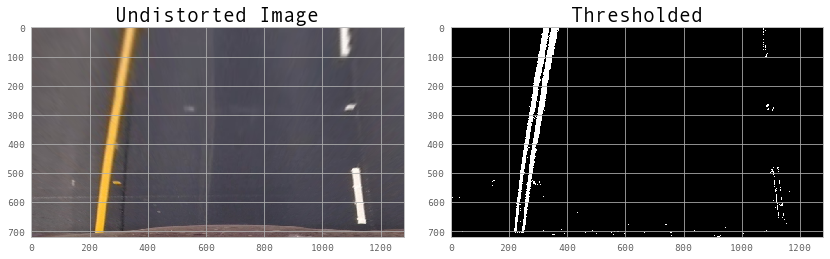

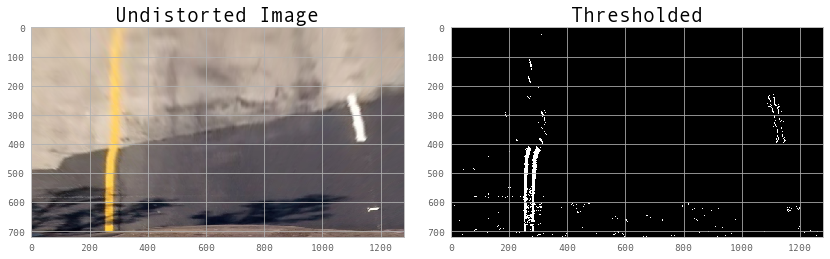

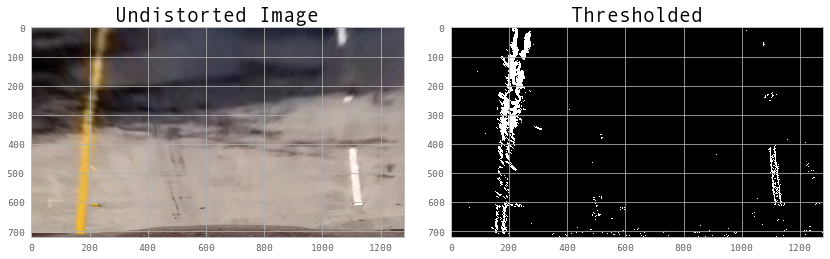

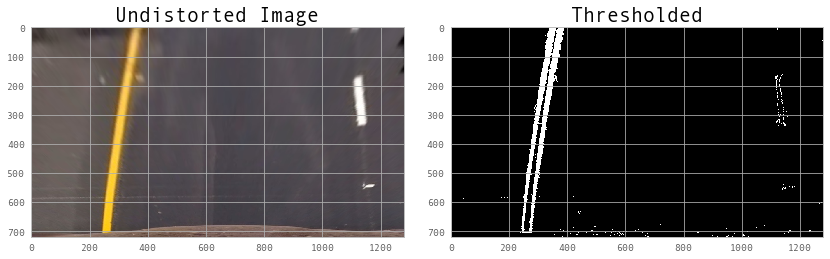

In [45]:
#def apply_thresholds(image):
for fname in glob.glob("test_images/test*.jpg"):
    image = mpimg.imread(fname)
    warped = transform_perspective(image, src, dst)
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    grad_x = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh_min=10, thresh_max=230)
    grad_y = abs_sobel_thresh(warped, orient='y', sobel_kernel=3, thresh_min=10, thresh_max=230)
    mag_binary = mag_thresh(warped, sobel_kernel=3, thresh_min=30, thresh_max=150)
    dir_binary = directional_thresh(warped, sobel_kernel=3, thresh_min=0.7, thresh_max=1.3)
    hls_binary = color_thresh(warped, thresh_min=80, thresh_max=255)
    combined = np.zeros_like(dir_binary)
    #print(dir_binary.shape, hls_binary.shape)
    combined[((grad_x == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[(hls_binary == 1) | (dir_binary == 1)] = 1
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(warped)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(combined,cmap='gray' )
    ax2.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)